# SocraticFlanT5 - Improved

## Introduction

In this notebook, we propose a new method to obtain image captions via the Socratic method.
This is an improved pipeline that has for goal to generate similar or improved captions using open-source and free models.

## Imports

In [25]:
# Package loading
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd

# Local imports
from image_captioning import ClipManager, ImageManager, VocabManager, FlanT5Manager, print_clip_info, create_lm_prompt
from utils import get_device

ImportError: cannot import name 'create_lm_prompt' from 'image_captioning' (/Users/ryanamaudruz/PycharmProjects/socraticmodels/image_captioning.py)

## Set device

In [8]:
# Set the device to use
device = get_device()

## Class instantiation

In [9]:
# Instantiate the clip manager
clip_manager = ClipManager(device)

# Instantiate the image manager
image_manager = ImageManager()

# Instantiate the vocab manager
vocab_manager = VocabManager()

# Instantiate the Flan T5 manager
flan_manager = FlanT5Manager()

# Print out clip model info
print_clip_info(clip_manager.model)

load_places starting!
load_places took 0.0s!
load_objects starting!
load_objects took 91.2s!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model parameters (total): 427616513
Model parameters (image encoder): 303966208
Model parameters (text encoder): 122999808
Input image resolution: 224
Context length: 77
Vocab size: 49408


## Set image path

In [10]:
img_paths = {
    'Monkey with gun': 'monkey_with_gun.jpg',
    'Cute bear': 'cute_bear.jpg',
    'Astronaut with beer': 'astronaut_with_beer.jpg'
}

## Create text embeddings

In [11]:
# Calculate the place features
place_feats = clip_manager.get_text_feats([f'Photo of a {p}.' for p in vocab_manager.place_list])

# Calculate the object features
object_feats = clip_manager.get_text_feats([f'Photo of a {o}.' for o in vocab_manager.object_list])

get_text_feats starting!
get_text_feats took 13.2s!
get_text_feats starting!
get_text_feats took 295.1s!


## Load image and compute image embedding

Monkey with gun:


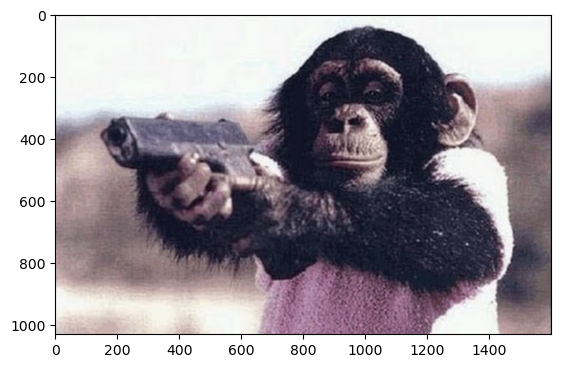

Cute bear:


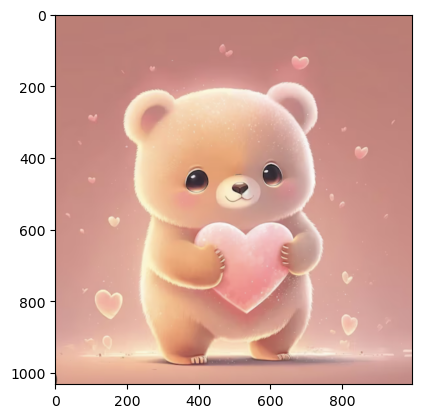

Astronaut with beer:


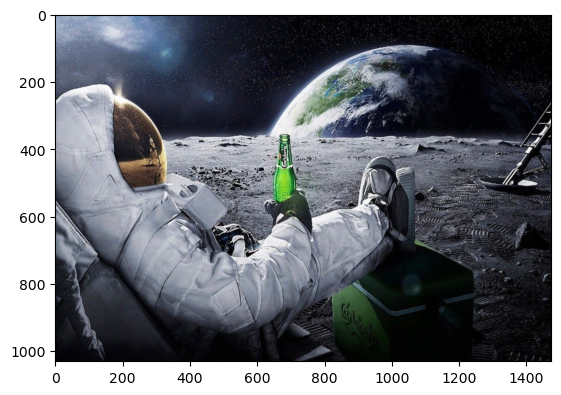

In [13]:
# Load image.
img_dic = {img_name: image_manager.load_image(img_path) for img_name, img_path in img_paths.items()}
# Get image representation
img_feat_dic = {img_name: clip_manager.get_img_feats(img) for img_name, img in img_dic.items()}
# Show the image
for img_name, img in img_dic.items():
    print(f'{img_name}:')
    plt.imshow(img)
    plt.show()

## Zero shot VLM - Image type classification

In [14]:
# Zero-shot VLM: classify image type.
img_types = ['photo', 'cartoon', 'sketch', 'painting']
img_types_feats = clip_manager.get_text_feats([f'This is a {t}.' for t in img_types])

# Create a dictionary to store the image types
img_type_dic = {}
for img_name, img_feat in img_feat_dic.items():
    sorted_img_types, img_type_scores = clip_manager.get_nn_text(img_types, img_types_feats, img_feat)
    img_type_dic[img_name] = sorted_img_types[0]
    print(f'Image type for "{img_name}": {img_type_dic[img_name]}')

get_text_feats starting!
get_text_feats took 0.4s!
Image type for "Monkey with gun": photo
Image type for "Cute bear": cartoon
Image type for "Astronaut with beer": photo


## Zero shot VLM - Number of people classification

In [16]:
# Zero-shot VLM: classify number of people.
ppl_texts = [
    'are no people', 'is one person', 'are two people', 'are three people', 'are several people', 'are many people'
]
ppl_feats = clip_manager.get_text_feats([f'There {p} in this photo.' for p in ppl_texts])

# Create a dictionary to store the number of people
num_people_dic = {}
for img_name, img_feat in img_feat_dic.items():
    sorted_ppl_texts, ppl_scores = clip_manager.get_nn_text(ppl_texts, ppl_feats, img_feat)
    num_people_dic[img_name] = sorted_ppl_texts[0]
    print(f'Number of people in "{img_name}": {num_people_dic[img_name]}')

get_text_feats starting!
get_text_feats took 0.2s!
Number of people in "Monkey with gun": is one person
Number of people in "Cute bear": is one person
Number of people in "Astronaut with beer": are no people


## Zero shot VLM - Image place classification

In [17]:
# Zero-shot VLM: classify places.
place_topk = 3

# Create a dictionary to store the number of people
location_dic = {}
for img_name, img_feat in img_feat_dic.items():
    sorted_places, places_scores = clip_manager.get_nn_text(vocab_manager.place_list, place_feats, img_feat)
    location_dic[img_name] = sorted_places[0]
    print(f'Location for {img_name}: {location_dic[img_name]}')

Location for Monkey with gun: veterinarians office
Location for Cute bear: childs room
Location for Astronaut with beer: beer garden


## Zero shot VLM - Image object classification

In [21]:
# Zero-shot VLM: classify objects.
obj_topk = 10

# Create a dictionary to store the similarity of each object with the images
object_score_map = {}
sorted_obj_dic = {}
for img_name, img_feat in img_feat_dic.items():
    sorted_obj_texts, obj_scores = clip_manager.get_nn_text(vocab_manager.object_list, object_feats, img_feat)
    object_score_map[img_name] = dict(zip(sorted_obj_texts, obj_scores))
    sorted_obj_dic[img_name] = sorted_obj_texts
    object_list = ''
    for i in range(obj_topk):
        object_list += f'{sorted_obj_texts[i]}, '
    object_list = object_list[:-2]
    print(f'Top 10 objects recognised for "{img_name}":\n{object_list}\n')

Top 10 objects recognised for "Monkey with gun":
chimpanzee, chimp, Pan troglodytes, anthropoid ape, lesser ape, central chimpanzee, Pan troglodytes troglodytes, monkey, ape, lawgiver, lawmaker, simian, primate, political scientist

Top 10 objects recognised for "Cute bear":
sweetheart, sweetie, steady, truelove, bear, forebear, forbear, lover, bear cub, honey, ninon, darling, favorite, favourite, pet, dearie, deary, ducky, call girl, teddy, teddy bear

Top 10 objects recognised for "Astronaut with beer":
astronaut, spaceman, cosmonaut, spacesuit, rest, futurist, diplomat, diplomatist, Homo sapiens sapiens, modern man, scientist, beer drinker, ale drinker, planking, social scientist



## Finding both relevant and different objects using the cosine similarity

In [27]:
# Create a dictionary that maps the objects to the cosine sim.
object_embeddings = dict(zip(vocab_manager.object_list, object_feats))

# Create a dictionary to store the terms to include
terms_to_include = {}

for img_name, sorted_obj_texts in sorted_obj_dic.items():

    # Create a list that contains the objects ordered by cosine sim.
    embeddings_sorted = [object_embeddings[w] for w in sorted_obj_texts]

    # Create a list to store the best matches
    best_matches = [sorted_obj_texts[0]]

    # Create an array to store the embeddings of the best matches
    unique_embeddings = embeddings_sorted[0].reshape(-1, 1)

    # Loop through the 100 best objects by cosine similarity
    for i in range(1, 100):
        # Obtain the maximum cosine similarity when comparing object i to the embeddings of the current best matches
        max_cos_sim = (unique_embeddings.T @ embeddings_sorted[i]).max()
        # If object i is different enough to the current best matches, add it to the best matches
        if max_cos_sim < 0.7:
            unique_embeddings = np.concatenate([unique_embeddings, embeddings_sorted[i].reshape(-1, 1)], 1)
            best_matches.append(sorted_obj_texts[i])

    # Looping through the best matches, consider each terms separately by splitting the commas and spaces.
    data_list = []
    for terms in best_matches:
        for term_split in terms.split(', '):
            score = clip_manager.get_image_caption_score(term_split, img_feat_dic[img_name])
            data_list.append({
                'term': term_split, 'score': score, 'context': terms
            })
            term_split_split = term_split.split(' ')
            if len(term_split_split) > 1:
                for term_split2 in term_split_split:
                    score = clip_manager.get_image_caption_score(term_split2, img_feat_dic[img_name])
                    data_list.append({
                        'term': term_split2, 'score': score, 'context': terms
                    })

    # Create a dataframe with the terms and scores and only keep the top term per context.
    term_df = pd.DataFrame(data_list).sort_values('score', ascending=False).drop_duplicates('context').reset_index(drop=True)

    # Prepare loop to find if additional terms can improve cosine similarity
    best_terms_sorted = term_df['term'].tolist()
    best_term = best_terms_sorted[0]
    terms_to_check = list(set(best_terms_sorted[1:]))
    best_cos_sim = term_df['score'].iloc[0]
    terms_to_include[img_name] = [best_term]

    # Perform a loop to find if additional terms can improve the cosine similarity
    n_iteration = 5
    for iteration in range(n_iteration):
        data_list = []
        for term_to_test in terms_to_check:
            new_term = f"{best_term} {term_to_test}"
            score = clip_manager.get_image_caption_score(new_term, img_feat_dic[img_name])
            data_list.append({
                'term': new_term, 'candidate': term_to_test, 'score': score
            })
        combined_df = pd.DataFrame(data_list).sort_values('score', ascending=False)
        if combined_df['score'].iloc[0] > best_cos_sim + 0.01:
            best_cos_sim = combined_df['score'].iloc[0]
            terms_to_include[img_name].append(combined_df['candidate'].iloc[0])
            terms_to_check = combined_df['candidate'].tolist()[1:]
            best_term += f" {combined_df['candidate'].iloc[0]}"
        else:
            break

get_text_feats starting!
get_text_feats took 0.5s!
get_text_feats starting!
get_text_feats took 0.0s!
get_text_feats starting!
get_text_feats took 0.0s!
get_text_feats starting!
get_text_feats took 0.0s!
get_text_feats starting!
get_text_feats took 0.1s!
get_text_feats starting!
get_text_feats took 0.1s!
get_text_feats starting!
get_text_feats took 0.1s!
get_text_feats starting!
get_text_feats took 0.1s!
get_text_feats starting!
get_text_feats took 0.1s!
get_text_feats starting!
get_text_feats took 0.1s!
get_text_feats starting!
get_text_feats took 0.0s!
get_text_feats starting!
get_text_feats took 0.0s!
get_text_feats starting!
get_text_feats took 0.0s!
get_text_feats starting!
get_text_feats took 0.0s!
get_text_feats starting!
get_text_feats took 0.0s!
get_text_feats starting!
get_text_feats took 0.0s!
get_text_feats starting!
get_text_feats took 0.1s!
get_text_feats starting!
get_text_feats took 0.1s!
get_text_feats starting!
get_text_feats took 0.0s!
get_text_feats starting!
get_te

## Zero shot LM - Caption generation

In [28]:
def create_lm_prompt(img_type, ppl_result, terms_to_include):
    return f'''Create a creative beautiful caption from this context:
    "This image is a {img_type}. There {ppl_result}.
    The context is: {', '.join(terms_to_include)}.
    A creative short caption I can generate to describe this image is:'''

In [38]:
# Generate 50 captions, order them and print out the best.
num_captions = 50

# Set LM params
model_params = {'temperature': 0.9, 'max_length': 40, 'do_sample': True}

# Create dictionaries to store the outputs
prompt_dic = {}
sorted_caption_map = {}
caption_score_map = {}

for img_name in img_dic:
    prompt_dic[img_name] = create_lm_prompt(img_type_dic[img_name], num_people_dic[img_name], terms_to_include[img_name])

    caption_texts = flan_manager.generate_response(num_captions * [prompt_dic[img_name]], model_params)

    # Zero-shot VLM: rank captions.
    caption_feats = clip_manager.get_text_feats(caption_texts)
    sorted_captions, caption_scores = clip_manager.get_nn_text(caption_texts, caption_feats, img_feat_dic[img_name])
    sorted_caption_map[img_name] = sorted_captions
    caption_score_map[img_name] = dict(zip(sorted_captions, caption_scores))
    print(f'Best generate caption for "{img_name}": "{sorted_captions[0]}"')

generate_response starting!
generate_response took 104.6s!
get_text_feats starting!
get_text_feats took 4.1s!
Best generate caption for "Monkey with gun": "a chimpanzee with a gun"
generate_response starting!
generate_response took 144.6s!
get_text_feats starting!
get_text_feats took 3.8s!
Best generate caption for "Cute bear": "sweetheart galantines and cooky is a great friend for a galantine when a person"
generate_response starting!
generate_response took 121.5s!
get_text_feats starting!
get_text_feats took 3.9s!
Best generate caption for "Astronaut with beer": "astronaut on the moon resting and drinking a cold beer on space lounge"
